# Import

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Auxiliary functions

In [2]:
models = list(Path("/Users/joseantem/Documents/TM/models").iterdir())
# models = list(Path("/home/joseantem/TM/models/").iterdir())
# for m in models:
#     print(m)

In [3]:
model_path = models[-1]
# with model_path.joinpath("config.json").open("r") as f:
#     config = json.load(f)
with model_path.joinpath("stats/tuned_params.json").open("r") as f:
    config = json.load(f)
print(config)

{'trainer': 'prodLDA', 'ndocs': 5000, 'n_components': 20, 'num_samples': 10, 'num_epochs': 10, 'model_type': 'LDA'}


In [4]:
def get_model_desc(model_path):
    """Loads model configuration"""
    with model_path.joinpath("stats/tuned_params.json").open("r") as f:
        model_desc = json.load(f)
    # with model_path.joinpath("config.json").open("r") as f:
    #     config = json.load(f)
    # tuned_params = {
    #     "ctm_model_type": None,
    #     "model_type": None,
    #     "ntopics": None,
    #     "n_components": None,
    #     "num_epochs": None,
    #     "num_iterations": None,
    #     "num_samples": None,
    # }
    # model_desc = {"trainer": config["trainer"], **{p: config["TMparam"][p]
    #                                                for p in tuned_params.keys() if p in config["TMparam"].keys()}}
    return model_desc


def get_tpc_labels(model_path):
    """Loads model topic labels"""
    with model_path.joinpath("TMmodel/tpc_labels.txt").open("r") as f:
        tpc_labels = [el.strip() for el in f.readlines()]
    return tpc_labels


def get_model_memory(model_path):
    """Loads model memory consumption"""
    model_stats = model_path.joinpath("stats")
    mem_use = pd.read_csv(model_stats.joinpath("mem_use.txt"))
    mem_proc = mem_use.groupby("process").agg(lambda x: list(x))

    # Compute cumsum values
    mem_proc = mem_proc.applymap(lambda x: np.array(x))
    mem_proc.loc["total"] = mem_proc.values.sum(axis=0)

    return mem_proc


def get_model_coherence(model_path):
    """Loads model coherence measures"""
    model_stats = model_path.joinpath("stats")
    with model_stats.joinpath("topic_coherence.json").open("r") as f:
        coherences = json.load(f)
    return coherences


def get_model_info(model_path: Path):
    """Obtain all necessary information of the model"""
    # Get parameters
    model_desc = get_model_desc(model_path)
    mem_proc = get_model_memory(model_path)
    coherences = get_model_coherence(model_path)
    tpc_labels = get_tpc_labels(model_path)

    info = {
        "model_desc": model_desc,
        "mem_proc": mem_proc,
        "coherences": coherences,
        "tpc_labels": tpc_labels,
    }

    return info


def moving_average(x, w=10):
    """Compute moving average of a numeric sequence"""
    return np.convolve(x, np.ones(w), "same") / w


# Show
- Model info
    - Characteristics (name, num topics...)
    - Coherence (add mean and tag by topic)
    - Plot memory (add mean, min, max, time, cumsum(all_processes))
- Compare models (for each)
    - Show characteristics as name
    - Plot coherence by time
    - Plot cumsum(all_processes)

In [5]:
def show_model_info(
    model_desc: dict,
    mem_proc: pd.DataFrame,
    coherences: list,
    tpc_labels: list,
):
    """
    Given model information returns two figures:
        - fig_mem: shows memory and cpu consumption by process in time
        - fig_coh: shows coherence measures by topic and their labels
    """

    measures = list(mem_proc.columns)
    processes = list(mem_proc.index)
    num_rows = len(measures)
    num_cols = 1
    seconds = list(range(len(mem_proc.iloc[0, 0])))

    # Define color palette
    color_palette = px.colors.qualitative.Vivid

#     # Create subplots
#     # # Shape
#     # [ [{"colspan":num_cols-1}, {}, {"rowspan": num_rows}],
#     #   [{"colspan":num_cols-1}, {},                    {}],
#     #   [{"colspan":num_cols-1}, {},                    {}], ]
#     specs = [[{} for c in range(num_cols)] for r in range(num_rows)]
#     specs[0][-1].update({"rowspan": num_rows})
#     [el[0].update({"colspan":num_cols-1}) for el in specs]
#     # # Titles
#     titles = [""] * num_cols * num_rows
#     for i, el in enumerate(range(0, num_cols*num_rows, num_cols)):
#         titles[el]=measures[i]

    fig_mem = make_subplots(
        rows=num_rows,
        cols=num_cols,
        shared_xaxes=True,
        subplot_titles=measures,
        #         specs=specs,
        x_title="seconds",
    )
    fig_coh = go.Figure()

    # Add traces
    for pos, m in enumerate(measures):
        for i, p in enumerate(processes):
            trace = go.Scatter(
                x=seconds,
                y=moving_average(mem_proc.loc[p, m]),
                name=p,
                visible=True,
                legendgroup=f"mem{p}",
                showlegend=pos == 0,
                marker={"color": color_palette[i]},
            )
            fig_mem.append_trace(trace, row=pos+1, col=1)

    # Add traces
    for pos, c in enumerate(coherences):
        coh = c["coherences"]
        m = c["measure"]
        nt = list(range(len(tpc_labels)))
        fig_coh.add_trace(go.Bar(
            x=coh,
            y=nt,
            name=m,
            visible=True,
            marker={"color": color_palette[pos]},
            orientation="h",
            legendgroup=f"coh{pos}",
            text=np.round(coh, 3),
            textposition="outside"
        ))

    # Create slider
    slider = {
        "autorange": True,
        "rangeslider": {
            "autorange": True,
            "thickness": 0.02,
            "yaxis": {
                "range": [-10, -2],
                "rangemode": "fixed"
            },
        },
    }

    legend = {
        "yanchor": "top",
        "y": 0.99,
        "xanchor": "left",
        "x": 1.05,
        "valign": "top",
    }

    title = {"text": ", ".join([f"{k}: {v}" for k, v in model_desc.items(
    )]), "x": 0.5, "xanchor": "center", "xref": "paper"}
    fig_mem.update_layout({
        "title": title,
        "margin": go.layout.Margin(l=80, r=60, t=140, b=80, autoexpand=True),
        # "autosize": False,
        "width": 800,
        "height": 600,
        "showlegend": True,
        "legend": legend,
        "legend_title_text": "Process",
        f"xaxis{num_rows}": slider,
        **{f"xaxis{el}_matches": "x" for el in range(1, num_rows+1)},
    })
    fig_coh.update_layout({
        "title": title,
        "xaxis_title": "coherence",
        "yaxis_title": "Topic label",
        "xaxis": {"autorange": "reversed"},
        "margin": go.layout.Margin(l=80, r=60, t=140, b=80, autoexpand=True),
        # "autosize": False,
        "width": 800,
        "height": 600,
        "showlegend": True,
        "legend": legend,
        "legend_title_text": "Coherence",
        "yaxis_tickvals": list(range(len(tpc_labels))),
        "yaxis_ticktext": [f"tp:{n} [{l}]" for n, l in enumerate(tpc_labels)],
    })

    return fig_mem, fig_coh


In [6]:
def compare_models_memory(models):
    """
    Given a list of model paths, compares the memory consumption by process and model type
    Returns a list of figures, one by model type (e.g. mallet, ctm)
    """

    # Read and merge all models info
    mem_proc = []
    for mp in models:
        try:
            inf = get_model_info(mp)
            md, mp, coh, tl = inf.values()

            # Memory
            r_index = "<br>".join([f"<b>{k}</b>:{v}" for k, v in md.items() if k!="trainer"]) + "<br>"
            columns = ["model"] + mp.loc["total"].index.tolist() + ["m_type"]
            values = [r_index] + mp.loc["total"].values.tolist() + \
                [md["trainer"]]
            mem_proc.append(pd.DataFrame(data=[values], columns=columns))
        except:
            pass
    mem_proc = pd.concat(mem_proc).groupby(
        ["m_type", "model"]).agg(lambda x: x)

    # Initial configuration
    measures = list(mem_proc.columns)
    model_types = mem_proc.index.get_level_values(0).unique().tolist()
    model_names = mem_proc.index.get_level_values(1).unique().tolist()
    color_by_type = {v: i for i, v in enumerate(model_types)}
    num_rows = len(measures)
    num_cols = 1

    figures = []

    for m_type in model_types:
        fig = make_subplots(
            rows=num_rows,
            cols=num_cols,
            shared_xaxes=True,
            subplot_titles=measures,
            x_title="seconds",
        )
        subgroup = mem_proc.loc[(m_type)]
        # Update color palette to match number of models
        n_colors = len(subgroup)
        color_palette = px.colors.sample_colorscale(
            "rainbow", [n/(n_colors-1) for n in range(n_colors)] if n_colors > 1 else [0])
        # Add traces
        for i, m in enumerate(measures):
            for c, (m_name, v) in enumerate(subgroup[m].items()):
                color = color_palette[c]
                seconds = list(range(len(v)))
                fig.append_trace(go.Scatter(
                    x=seconds,
                    y=moving_average(v),
                    legendgroup=m_name,
                    name=m_name,
                    showlegend=i == 0,
                    mode="lines",
                    marker={"color": color, "symbol": c, "size": 12},
                    text=m_name,
                    textposition="top center",
                ),
                    row=i+1, col=1)

        # Create slider
        slider = {
            "autorange": True,
            "rangeslider": {
                "autorange": True,
                "thickness": 0.02,
                "yaxis": {
                    "range": [-10, -2],
                    "rangemode": "fixed"
                },
            },
        }

        legend = {
            "yanchor": "top",
            "y": 0.99,
            "xanchor": "left",
            "x": 1.05,
            "valign": "top",
        }

        fig.update_layout({
            "title": {"text": f"Model comparison: {m_type}", "x": 0.5, "xanchor": "center", "xref": "paper"},
            "margin": go.layout.Margin(l=80, r=60, t=140, b=80, autoexpand=True),
            # "autosize": False,
            "width": 800,
            "height": 600,
            "showlegend": True,
            "legend": legend,
            f"xaxis{num_rows}": slider,
            **{f"xaxis{el}_matches": "x" for el in range(1, num_rows+1)},
        })

        figures.append(fig)
    return figures


In [7]:
def compare_models_coherence(models):
    """
    Given a list of model paths, compares the memory consumption by process and model type
    Returns a list of figures, one by model type (e.g. mallet, ctm)
    """

    # Read and merge all models info
    coherences = []
    for mp in models:
        try:
            inf = get_model_info(mp)
            md, mp, coh, tl = inf.values()

            # Coherence
            r_index = "<br>".join([f"<b>{k}</b>:{v}" for k, v in md.items() if k!="trainer"]) + "<br>"
            columns = ["model", "measure", "coherences", "time", "m_type"]
            values = [[r_index, c["measure"], c["coherences"], len(mp.iloc[0, 0]), md["trainer"]] for c in coh]
            coherences.append(pd.DataFrame(data=values, columns=columns))
        except:
            pass
    coherences = pd.concat(coherences).groupby(
        ["measure", "m_type", "model"]).agg(lambda x: x)

    # Initial configuration
    measures = coherences.index.get_level_values(0).unique().tolist()
    model_types = coherences.index.get_level_values(1).unique().tolist()
    model_names = coherences.index.get_level_values(2).unique().tolist()
    color_by_type = {v: i for i, v in enumerate(model_types)}
    figures = []

    # Define color palette
    color_palette = px.colors.qualitative.Vivid

    for m in measures:
        fig = go.Figure()
        for m_type in model_types:
            for i, (m_name, v) in enumerate(coherences.loc[(m, m_type)].iterrows()):
                coh = coherences.loc[(m, m_type, m_name)]
                color = color_palette[color_by_type[m_type]]
                # Add traces
                fig.add_trace(go.Scatter(
                    x=[coh["time"]],
                    y=[np.mean(coh["coherences"])],
                    legendgroup=m_type,
                    legendgrouptitle_text=m_type,
                    name=m_name,
                    mode="markers",  # +text",
                    marker={"color": color, "symbol": i, "size": 12},
                    text=m_name,
                    textposition="top center",
                ))

        legend = {
            "yanchor": "top",
            "y": 0.99,
            "xanchor": "left",
            "x": 1.05,
            "groupclick": "toggleitem",
            "valign": "top",
        }

        updatemenus = [
            {
                "buttons": [
                    {
                        "args": [{"visible": True}],
                        "args2": [{"visible": False}],
                        "label": "All",
                        "method": "restyle",
                        "visible": True,
                    }
                ]
                + [
                    {
                        "args": [
                            {"visible": True},
                            [n for n, l in enumerate(fig.data) if l.legendgroup == m_type],
                        ],
                        "args2": [
                            {"visible": False},
                            [n for n, l in enumerate(fig.data) if l.legendgroup == m_type],
                        ],
                        "label": m_type,
                        "method": "restyle",
                        "visible": True,
                    }
                    for m_type in model_types
                ],
                "type": "buttons",
                "active": 0,
                "direction": "right",
                "pad": {"r": 20, "t": 20},
                "showactive": True,
                "yanchor": "top",
                "y": 1.25,
                "xanchor": "left",
                "x": 1.05,
            }
        ]

        fig.update_layout({
            "title": {"text": f"Model comparison: {m} coherence", "x": 0.5, "xanchor": "center", "xref": "paper"},
            "xaxis_title": "time",
            "yaxis_title": "coherence",
            #         "yaxis": {"autorange": "reversed"},
            "margin": go.layout.Margin(l=80, r=60, t=140, b=80, autoexpand=True),
            #         "autosize": False,
            "width": 800,
            "height": 600,
            "showlegend": True,
            "legend": legend,
            "updatemenus": updatemenus,
        })
        figures.append(fig)

    return figures


In [8]:
models = list(Path("/Users/joseantem/Documents/TM/models").iterdir())
# models = list(Path("/home/joseantem/TM/models/").iterdir())
for m in models:
    print(m)


/Users/joseantem/Documents/TM/models/mallet_5000_10_500_2_20220812
/Users/joseantem/Documents/TM/models/mallet_5000_20_100_4_20220812
/Users/joseantem/Documents/TM/models/mallet_5000_10_500_8_20220812
/Users/joseantem/Documents/TM/models/.DS_Store
/Users/joseantem/Documents/TM/models/mallet_10000_20_100_8_20220812
/Users/joseantem/Documents/TM/models/prodLDA_5000_20_10_10_prodLDA_20220812
/Users/joseantem/Documents/TM/models/prodLDA_5000_10_20_10_LDA_20220812
/Users/joseantem/Documents/TM/models/mallet_10000_10_500_4_20220812
/Users/joseantem/Documents/TM/models/mallet_10000_20_100_2_20220812
/Users/joseantem/Documents/TM/models/prodLDA_5000_10_10_10_prodLDA_20220812
/Users/joseantem/Documents/TM/models/mallet_10000_10_500_8_20220812
/Users/joseantem/Documents/TM/models/mallet_10000_10_500_2_20220812
/Users/joseantem/Documents/TM/models/mallet_10000_20_100_4_20220812
/Users/joseantem/Documents/TM/models/mallet_5000_10_500_4_20220812
/Users/joseantem/Documents/TM/models/mallet_5000_20_1

In [9]:
# for mp in models:
#     try:
#         inf = get_model_info(mp)
#         fig_m, fig_c = show_model_info(**inf)
#         fig_m.show()
#         fig_c.show()
#     except Exception as e:
#         pass


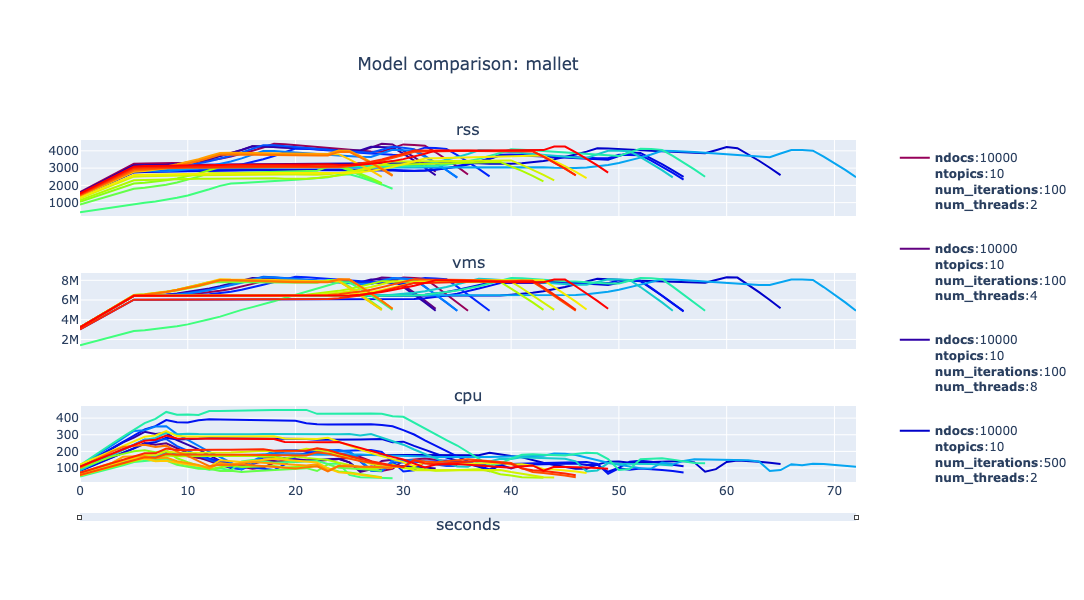

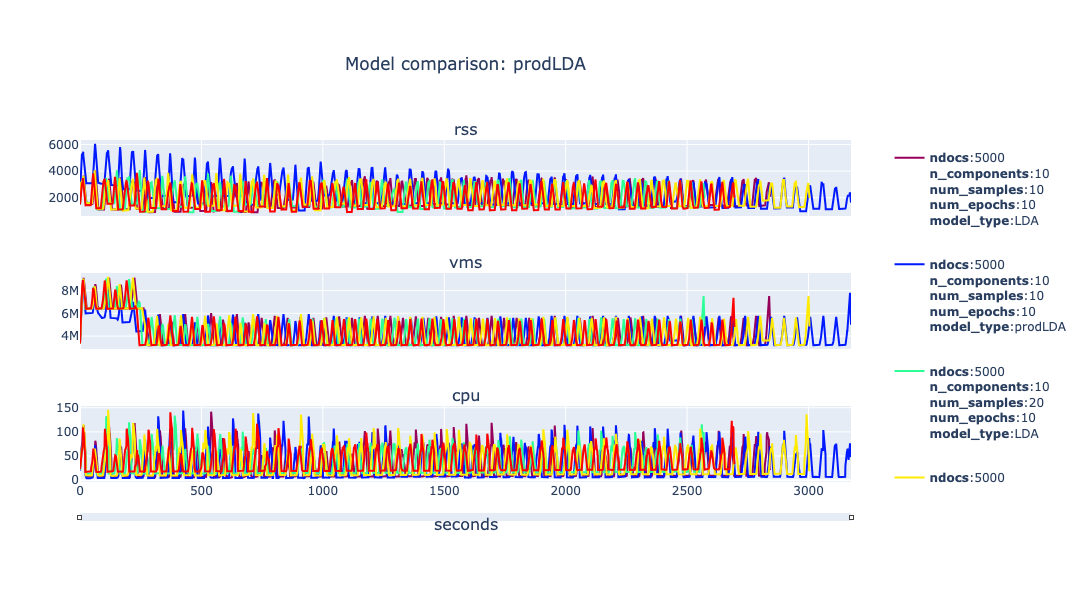

In [10]:
for fig in compare_models_memory(models):
    fig.show()


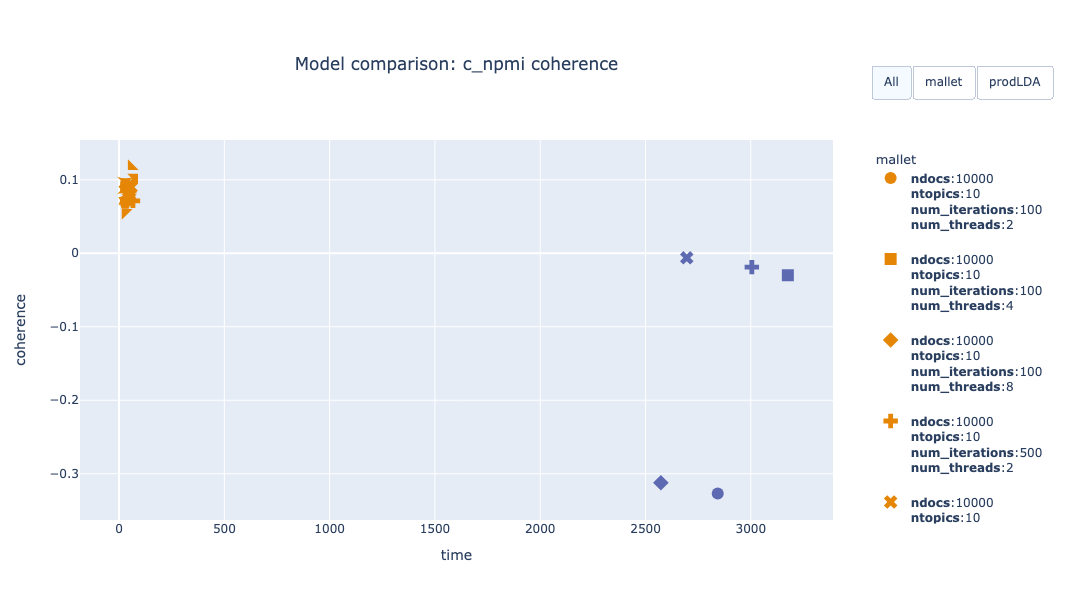

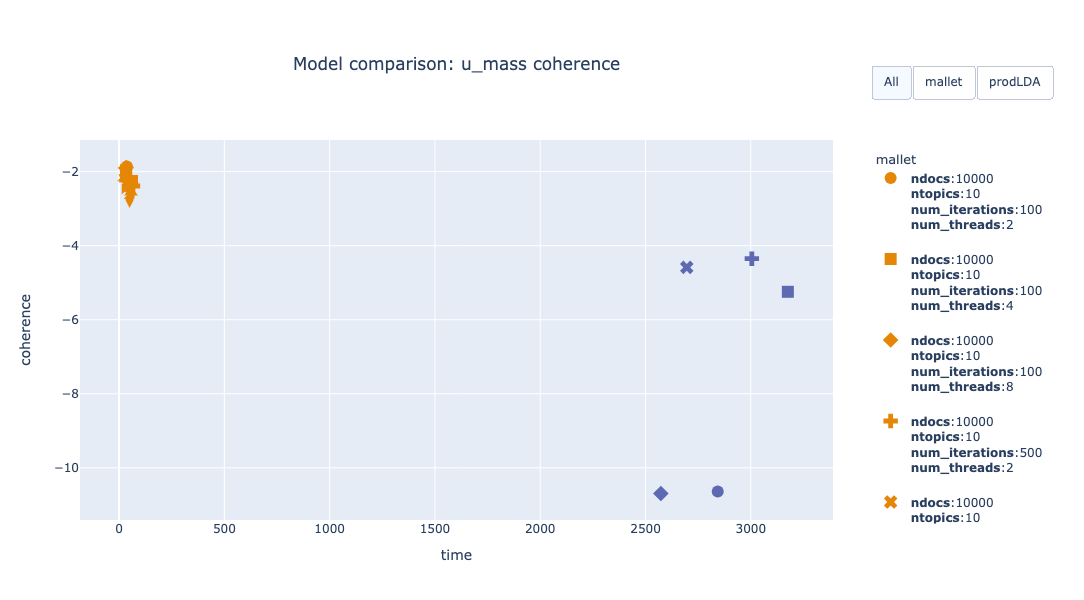

In [11]:
for fig in compare_models_coherence(models):
    fig.show()


In [12]:
# mem_proc = []
# coherences = []
# for mp in models:
#     #     mp = models[i]
#     try:
#         inf = get_model_info(mp)
#         md, mp, coh, tl = inf.values()

#         # Memory
#         r_index = "_".join([f"{v}" for k, v in md.items()])
#         columns = ["model"] + mp.loc["total"].index.tolist() + ["m_type"]
#         values = [r_index] + mp.loc["total"].values.tolist() + [md["trainer"]]
#         mem_proc.append(pd.DataFrame(data=[values], columns=columns))

#         # Coherence
#         columns = ["model", "measure", "coherences", "time", "m_type"]
#         values = [[r_index]+list(c.values())+[md["trainer"]] for c in coh]
#         coherences.append(pd.DataFrame(data=values, columns=columns))
#     except:
#         pass

# # mem_proc = pd.concat(mem_proc).set_index("model")
# mem_proc = pd.concat(mem_proc).groupby(["m_type", "model"]).agg(lambda x: x)
# coherences = pd.concat(coherences).groupby(
#     ["measure", "m_type", "model"]).agg(lambda x: x)
# # .pivot(index="model", columns=["measure"], values=["coherences", "time"])
# # .set_index("model")


In [13]:
# fig.write_html("plot.html")
